In [4]:
import sys
sys.path.append("../util/")

import numpy as np
import matplotlib.pyplot as plt

In [5]:
def phi1(x1, x2):
    return ((1+np.dot(x1, x2))**5)

def phi(x1, x2, sigma=5):
    return np.exp(-np.linalg.norm(np.subtract(x1, x2)**2)/(2*sigma))

def phi2(x1, x2, beta0=1.0, beta1=0.0):
    return np.tanh(beta0*np.dot(x1, x2)+beta1)


def support_vector_machine(dataset, C=0.6, epsilon=0.00001, epochs=100):
    bias = 0.0
    alphas = np.zeros(dataset.shape[0])
    K = np.array([[phi(i, j) for j in dataset[:, :2]] for i in dataset[:, :2]])
    count = 0
    numChanged = 0
    isReadyForNewLoop = True
    while ((count<epochs) and (isReadyForNewLoop or (numChanged>0))):
        numChanged = 0
        for i in range(dataset.shape[0]):
            if (isReadyForNewLoop or ((alphas[i]>0) and (alphas[i]<C))):
                Ei = np.dot(K[i, :], np.multiply(alphas, dataset[:, 2]))+bias-dataset[i, 2]
                tmp = dataset[i, 2]*Ei
                if (((tmp < -epsilon) and (alphas[i] < C)) or \
                    ((tmp > epsilon) and (alphas[i] > 0))):
                    maxDeltaE = 0.0
                    j = -1
                    for _j in range(dataset.shape[0]):
                        if ((alphas[_j]>0) and (alphas[_j]<C)):
                            E = np.dot(K[_j, :], np.multiply(alphas, dataset[:, 2]))+bias-dataset[_j, 2]
                            deltaE = np.fabs(Ei-E)
                            if (deltaE>maxDeltaE):
                                j = _j
                                maxDeltaE = deltaE
                                Ej = E
                    if (j<0):
                        j = i
                        while (j==i):
                            j = np.random.randint(0, dataset.shape[0])
                        Ej = np.dot(K[j, :], np.multiply(alphas, dataset[:, 2]))+bias-dataset[j, 2]
                    alphaI = alphas[i].copy()
                    alphaJ = alphas[j].copy()
                    if (dataset[i, 2] != dataset[j, 2]):
                        L = max(0, alphas[j] - alphas[i])
                        H = min(C, C + alphas[j] - alphas[i])
                    else:
                        L = max(0, alphas[j] + alphas[i] - C)
                        H = min(C, alphas[j] + alphas[i])
                    if (L==H):
                        #print("L==H")
                        continue
                    eta = 2.0*K[i, j] - K[i, i] - K[j, j]
                    if (eta>=0):
                        #print("eta>=0")
                        continue
                    alphas[j] -= dataset[j, 2]*(Ei-Ej)/eta
                    if (alphas[j]>H):
                        alphas[j] = H
                    elif (alphas[j]<L):
                        alphas[j] = L
                    if (np.fabs(alphas[j] - alphaJ) < 0.00001):
                        #print("j not moving enough")
                        continue
                    alphas[i] += dataset[j, 2]*dataset[i, 2]*(alphaJ - alphas[j])
                    bias1 = bias - Ei \
                         -dataset[i, 2]*(alphas[i]-alphaI)*K[i, i] \
                         -dataset[j, 2]*(alphas[j]-alphaJ)*K[i, j]
                    bias2 = bias - Ej \
                         -dataset[i, 2]*(alphas[i]-alphaI)*K[i, j] \
                         -dataset[j, 2]*(alphas[j]-alphaJ)*K[j, j]
                    if (0 < alphas[i]) and (C > alphas[i]):
                        bias = bias1
                    elif ((0 < alphas[j]) and (C > alphas[j])):
                        bias = bias2
                    else:
                        bias = (bias1 + bias2)/2.0
                    numChanged += 1
        count += 1
        if isReadyForNewLoop:
            isReadyForNewLoop = False
        elif (numChanged==0):
            isReadyForNewLoop = True
    return bias, alphas

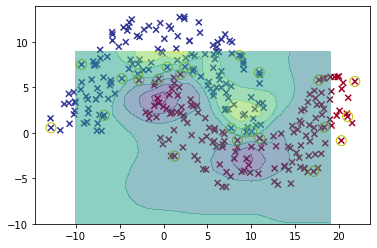

In [6]:
if __name__ == "__main__":
    from ipynb.fs.full.data_generator_2d import double_moon, visualize_data
    dataset = double_moon(300, d=-6.5)
    b, alphas = support_vector_machine(dataset, C=np.inf)
    support_vectors_indexes = np.nonzero(alphas>0)[0]
    support_vectors = dataset[support_vectors_indexes]
    fig = plt.figure()
    ax = fig.subplots(1, 1)
    visualize_data(dataset, ax)
    ax.scatter(dataset[np.nonzero(alphas>0), 0], dataset[np.nonzero(alphas>0), 1], marker="o", color="", edgecolors="y", s=100)
    x = np.arange(-10,20)
    y = np.arange(-10,10)
    desired = np.zeros((y.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            desired[j, i] = np.dot(np.array([phi(sv, np.array([x[i],y[j]])) for sv in support_vectors[:, :2]]), np.multiply(alphas[support_vectors_indexes], support_vectors[:, 2]))+b
    plt.contourf(x, y, desired, alpha=0.5)
    #y = np.matmul(np.array([[phi(i, j) for i in support_vectors[:, :2]] for j in dataset[:, :2]]), np.multiply(alphas[support_vectors_indexes], support_vectors[:, 2]))+b
    #plt.scatter(dataset[:, 0], dataset[:, 1], color=plt.cm.RdBu(np.sign(y)), marker="x")
    plt.show()